In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('YouTube_EDA').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/23 20:04:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/23 20:04:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/03/23 20:04:18 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


## USA

In [2]:
# Load the data
import os
current_path = os.getcwd()
full_path = f'file://{current_path}/US_youtube_trending_data_clean.csv'
df = spark.read.csv(full_path, inferSchema = True, header = True)
df.printSchema()

[Stage 1:>                                                          (0 + 4) / 4]

root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publishedAt: timestamp (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- trending_date: timestamp (nullable = true)
 |-- tags: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- _c15: string (nullable = true)



In [3]:
# get rid of last empty column that spark inferschema made
df = df.drop("_c15")
df.show(5)

+-----------+--------------------+-------------------+--------------------+-------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+
|   video_id|               title|        publishedAt|           channelId| channelTitle|categoryId|      trending_date|                tags|view_count| likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|
+-----------+--------------------+-------------------+--------------------+-------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+
|3C66w5Z0ixs|I ASKED HER TO BE...|2020-08-11 19:20:14|UCvtRTOMP2TqYqu51...|     Brawadis|        22|2020-08-12 00:00:00|brawadis|prank|ba...|   1514614|156908|    5855|        35313|https://i.ytimg.c...|            false|           false|
|M9Pmf9AB4Mo|Apex Legends | St...|2020-08-11

In [4]:
import pyspark.sql.functions as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [43]:
# clean data, drop bad records
print('Rows with no views: ' + str(df.filter(df['view_count'] == 0).count()))
print('Total rows: ' + str(df.count()))

Rows with no views: 80
Total rows: 268787


In [5]:
# Filter out rows with view_count = 0
df = df.filter(F.col("view_count") != 0)
print('Updated rows: ' + str(df.count()))

[Stage 3:=============================>                             (2 + 2) / 4]

Updated rows: 268707


In [6]:
df.groupBy("comments_disabled").count().show()

# Filter out rows with no comments
df = df.filter(F.col("comments_disabled") != 'true')

[Stage 6:=============================>                             (2 + 2) / 4]

+-----------------+------+
|comments_disabled| count|
+-----------------+------+
|             true|  3456|
|            false|265251|
+-----------------+------+



Total videos: 265251
Distinct video IDs: 46526
+-----------+-----+
|   video_id|count|
+-----------+-----+
|tnTPaLOaHz8|   37|
|3ryID_SwU5E|   37|
|hdmx71UjBXs|   36|
|J_z-W4UVHkw|   36|
|9RhWXPcKBI8|   36|
|QdBZY2fkU-0|   36|
|KOEfDvr4DcQ|   36|
|tWYsfOSY9vY|   36|
|aONT7atzqfw|   35|
|yhB3BgJyGl8|   35|
+-----------+-----+
only showing top 10 rows



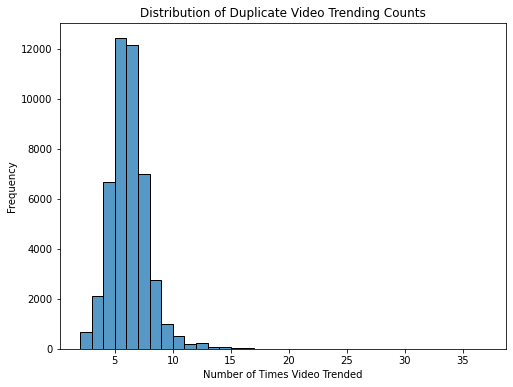

In [46]:
# eda for video ids, getting videos that trended most often too 
# Count total rows and distinct video IDs
total_videos = df.count()
distinct_videos = df.select("video_id").distinct().count()
print("Total videos:", total_videos)
print("Distinct video IDs:", distinct_videos)

# find video_ids that occur more than once (duplicate entries)
duplicates = df.groupBy("video_id").count().filter("count > 1").orderBy("count", ascending = False)
duplicates.show(10)

duplicates_pd = duplicates.toPandas()

plt.figure(figsize=(8,6))
sns.histplot(duplicates_pd['count'], bins=35)
plt.title("Distribution of Duplicate Video Trending Counts")
plt.xlabel("Number of Times Video Trended")
plt.ylabel("Frequency")
plt.show()

+------------------------------------------------------------+------------+----------+
|title                                                       |title_length|word_count|
+------------------------------------------------------------+------------+----------+
|I ASKED HER TO BE MY GIRLFRIEND...                          |34          |7         |
|Apex Legends | Stories from the Outlands – “The Endorsement”|60          |10        |
|I left youtube for a month and THIS is what happened.       |53          |11        |
|XXL 2020 Freshman Class Revealed - Official Announcement    |56          |8         |
|Ultimate DIY Home Movie Theater for The LaBrant Family!     |55          |9         |
+------------------------------------------------------------+------------+----------+
only showing top 5 rows

+-------+------------------+------------------+
|summary|      title_length|        word_count|
+-------+------------------+------------------+
|  count|            265251|            265251|


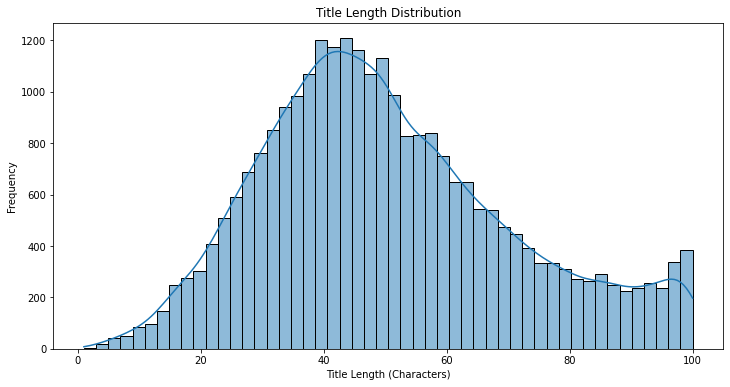

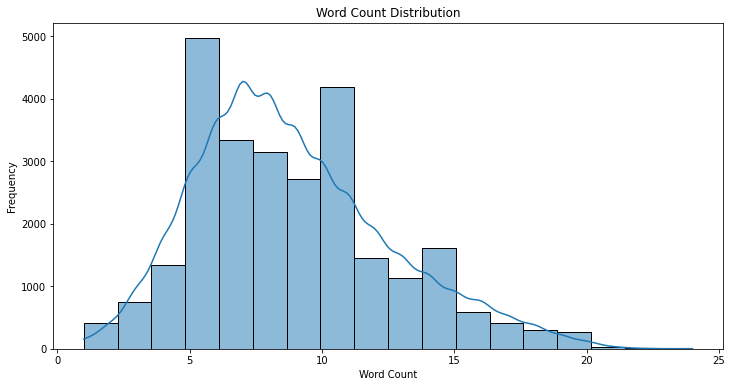

In [47]:
# adding title statistics and seeing statistics 
# Create a column for the length of each title (number of characters)
df = df.withColumn("title_length", F.length("title"))

# Create a column for the word count (splitting on whitespace)
df = df.withColumn("word_count", F.size(F.split("title", " ")))

# View sample titles with computed lengths and word counts
df.select("title", "title_length", "word_count").show(5, truncate=False)

# Get summary statistics on title length and word count
df.select("title_length", "word_count").describe().show()

# take sample
sample_titles = df.select("title_length", "word_count").sample(fraction=0.10, seed=42).toPandas()

# Plot 1: Title Length Distribution
plt.figure(figsize=(12, 6))
sns.histplot(sample_titles["title_length"], bins=50, kde=True)
plt.title("Title Length Distribution")
plt.xlabel("Title Length (Characters)")
plt.ylabel("Frequency")
plt.show()

# Plot 2: Word Count Distribution
plt.figure(figsize=(12, 6))
sns.histplot(sample_titles["word_count"], bins=18, kde=True)
plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

In [48]:
# looking at publishing and time features

# Extract year, month, and day of week from publishedAt
df = df.withColumn("publish_year", F.year("publishedAt")).withColumn("publish_month", F.month("publishedAt")).withColumn("publish_dayofweek", F.dayofweek("publishedAt")).withColumn("publish_hour", F.hour("publishedAt"))

# Show a sample of the new time-related columns
df.select("publishedAt", "publish_year", "publish_month", "publish_dayofweek", "publish_hour").show(5)

# Group by publish year to see counts per year
df.groupBy("publish_year").count().orderBy("publish_year").show()


+-------------------+------------+-------------+-----------------+------------+
|        publishedAt|publish_year|publish_month|publish_dayofweek|publish_hour|
+-------------------+------------+-------------+-----------------+------------+
|2020-08-11 15:20:14|        2020|            8|                3|          15|
|2020-08-11 13:00:10|        2020|            8|                3|          13|
|2020-08-11 12:34:06|        2020|            8|                3|          12|
|2020-08-11 12:38:55|        2020|            8|                3|          12|
|2020-08-11 11:10:05|        2020|            8|                3|          11|
+-------------------+------------+-------------+-----------------+------------+
only showing top 5 rows

+------------+-----+
|publish_year|count|
+------------+-----+
|        2020|28297|
|        2021|73025|
|        2022|72321|
|        2023|71664|
|        2024|19944|
+------------+-----+



+-------------+-----+
|publish_month|count|
+-------------+-----+
|            1|23614|
|            2|22992|
|            3|24009|
|            4|19745|
|            5|17958|
|            6|19923|
|            7|17988|
|            8|23389|
|            9|23207|
|           10|24689|
|           11|22616|
|           12|25121|
+-------------+-----+



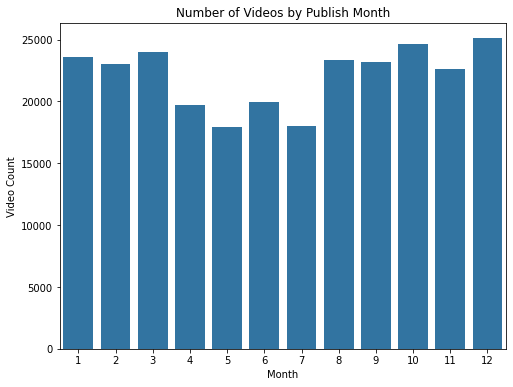

In [49]:
# Aggregate count by month of publication
monthly_counts = df.groupBy(F.month("publishedAt").alias("publish_month")).count().orderBy("publish_month")
monthly_counts.show()

# Convert to Pandas for plotting
monthly_pd = monthly_counts.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="publish_month", y="count", data=monthly_pd)
plt.title("Number of Videos by Publish Month")
plt.xlabel("Month")
plt.ylabel("Video Count")
plt.show()


+-----------+-----+
|publish_day|count|
+-----------+-----+
|          1|38738|
|          2|36855|
|          3|38502|
|          4|37626|
|          5|36984|
|          6|41894|
|          7|34652|
+-----------+-----+



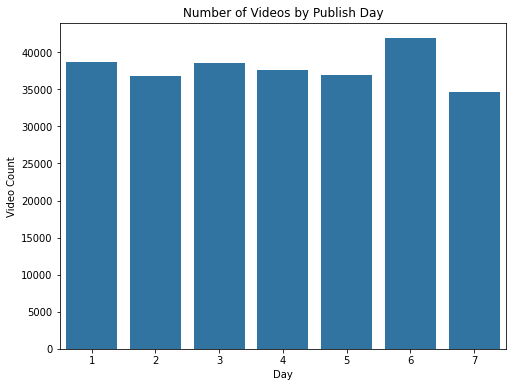

In [50]:
# Aggregate count by month of publication
weekly_counts = df.groupBy(F.dayofweek("publishedAt").alias("publish_day")).count().orderBy("publish_day")
weekly_counts.show()

# Convert to Pandas for plotting
weekly_pd = weekly_counts.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="publish_day", y="count", data=weekly_pd)
plt.title("Number of Videos by Publish Day")
plt.xlabel("Day")
plt.ylabel("Video Count")
plt.show()


+------------+-----+
|publish_hour|count|
+------------+-----+
|           0|14639|
|           1| 3664|
|           2| 2450|
|           3| 2134|
|           4| 2529|
|           5| 3146|
|           6| 2821|
|           7| 3927|
|           8| 8394|
|           9|14113|
|          10|17877|
|          11|22952|
|          12|27455|
|          13|20703|
|          14|15256|
|          15|18001|
|          16|15041|
|          17|14567|
|          18|13010|
|          19|11414|
+------------+-----+
only showing top 20 rows



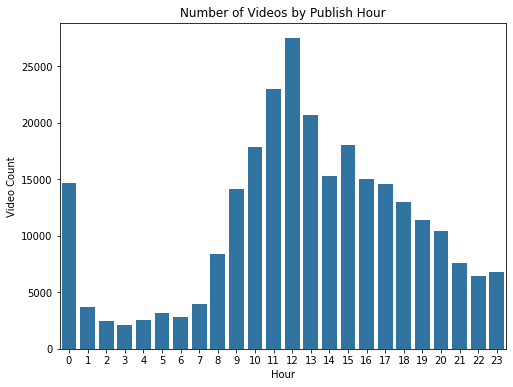

In [51]:
# Aggregate count by month of publication
hourly_counts = df.groupBy(F.hour("publishedAt").alias("publish_hour")).count().orderBy("publish_hour")
hourly_counts.show()

# Convert to Pandas for plotting
hourly_pd = hourly_counts.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="publish_hour", y="count", data=hourly_pd)
plt.title("Number of Videos by Publish Hour")
plt.xlabel("Hour")
plt.ylabel("Video Count")
plt.show()

In [52]:
# Count how many trending videos each channel has
df.groupBy("channelId", "channelTitle").count().orderBy("count", ascending=False).show(10)

+--------------------+------------------+-----+
|           channelId|      channelTitle|count|
+--------------------+------------------+-----+
|UCDVYQ4Zhbm3S2dlz...|               NFL| 1793|
|UCWJ2lWNubArHWmf3...|               NBA| 1489|
|UCX6OQ3DkcsbYNE6H...|           MrBeast| 1127|
|UCqZQlzSHbVJrwrn5...|        NBC Sports|  802|
|UCRijo3ddMTht_IHy...|      Dude Perfect|  699|
|UCiWLfSweyRNmLpgE...|              ESPN|  695|
|UCo_IB5145EVNcf8h...|The Game Theorists|  674|
|UCPD_bxCRGpmmeQcb...|    First We Feast|  640|
|UCke6I9N4KfC968-y...|           SSundee|  629|
|UCpB959t8iPrxQWj7...|      SSSniperWolf|  599|
+--------------------+------------------+-----+
only showing top 10 rows



In [53]:
# mapping categoryid to its value through joining json file
json_path = f'file://{os.getcwd()}/US_category_id.json'


categories_df = spark.read.option("multiLine", "true").json(json_path)
categories_df = categories_df.select(F.explode("items").alias("item"))
categories_df = categories_df.select(
    F.col("item.id").alias("categoryId"),
    F.col("item.snippet.title").alias("categoryTitle")
)

# Cast categoryId to integer so it matches your main DataFrame
categories_df = categories_df.withColumn("categoryId", F.col("categoryId").cast("integer"))

# Show the categories for verification
categories_df.show(truncate=False)


+----------+---------------------+
|categoryId|categoryTitle        |
+----------+---------------------+
|1         |Film & Animation     |
|2         |Autos & Vehicles     |
|10        |Music                |
|15        |Pets & Animals       |
|17        |Sports               |
|18        |Short Movies         |
|19        |Travel & Events      |
|20        |Gaming               |
|21        |Videoblogging        |
|22        |People & Blogs       |
|23        |Comedy               |
|24        |Entertainment        |
|25        |News & Politics      |
|26        |Howto & Style        |
|27        |Education            |
|28        |Science & Technology |
|29        |Nonprofits & Activism|
|30        |Movies               |
|31        |Anime/Animation      |
|32        |Action/Adventure     |
+----------+---------------------+
only showing top 20 rows



+---------------------+-----+
|categoryTitle        |count|
+---------------------+-----+
|Entertainment        |53268|
|Gaming               |52741|
|Music                |43310|
|Sports               |31260|
|People & Blogs       |22270|
|Comedy               |13168|
|Film & Animation     |10811|
|News & Politics      |8685 |
|Science & Technology |7556 |
|Howto & Style        |7045 |
|Education            |6605 |
|Autos & Vehicles     |5486 |
|Travel & Events      |1710 |
|Pets & Animals       |1222 |
|Nonprofits & Activism|114  |
+---------------------+-----+



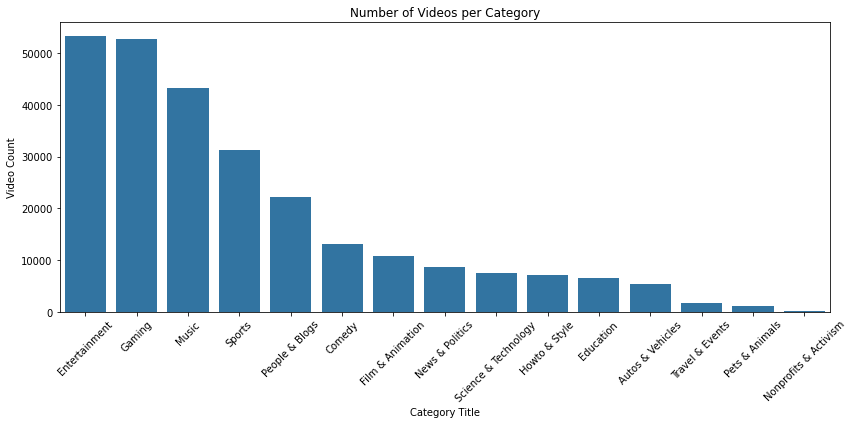

In [54]:
# Join the main DataFrame 'df' with the categories DataFrame
df_with_categories = df.join(categories_df, on="categoryId", how="left")

# Group by categoryTitle and count videos
category_counts = df_with_categories.groupBy("categoryTitle").count().orderBy("count", ascending=False)
category_counts.show(truncate=False)

# Convert to Pandas for visualization
category_counts_pd = category_counts.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x="categoryTitle", y="count", data=category_counts_pd)
plt.title("Number of Videos per Category")
plt.xlabel("Category Title")
plt.ylabel("Video Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

75th percentile of view counts: 2094042.0


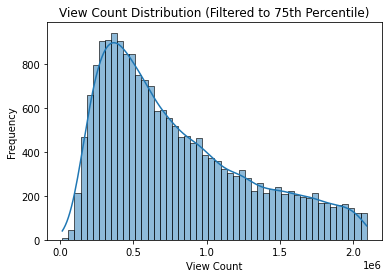

In [55]:
# Convert a sample to Pandas for a histogram
sample_views = df.select("view_count").sample(fraction=0.10, seed=42).toPandas()

# Determine a threshold: the 75th percentile of view counts
threshold = sample_views["view_count"].quantile(0.75)
print("75th percentile of view counts:", threshold)

# Filter the data to include only view counts below the threshold
filtered_sample_views = sample_views[sample_views["view_count"] <= threshold]

# Plot the histogram with the actual view count values
sns.histplot(filtered_sample_views["view_count"], bins=50, kde=True)
plt.title("View Count Distribution (Filtered to 75th Percentile)")
plt.xlabel("View Count")
plt.ylabel("Frequency")
plt.show()


+-------+------------------+
|summary|             likes|
+-------+------------------+
|  count|            265251|
|   mean|132552.04154555497|
| stddev| 456705.0148504979|
|    min|                 0|
|    max|          16021534|
+-------+------------------+

+------+----------+-----------+
| likes|view_count|likes_ratio|
+------+----------+-----------+
|156908|   1514614|        0.1|
|146739|   2381688|       0.06|
|353787|   2038853|       0.17|
| 23251|    496771|       0.05|
| 45802|   1123889|       0.04|
+------+----------+-----------+
only showing top 5 rows



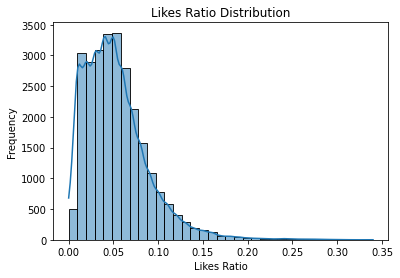

In [56]:
# Summary statistics for likes
df.select("likes").describe().show()

# Create a ratio column to see likes per view
df = df.withColumn("likes_ratio", F.round(F.col("likes") / F.col("view_count"), 2))
df.select("likes", "view_count", "likes_ratio").show(5)

# Take a 10% sample of the data for visualization
sample_likes_ratio = df.select("likes_ratio").sample(fraction=0.10, seed=42).toPandas()

# Plot the histogram for the likes_ratio distribution
sns.histplot(sample_likes_ratio["likes_ratio"], bins=35, kde=True)
plt.title("Likes Ratio Distribution")
plt.xlabel("Likes Ratio")
plt.ylabel("Frequency")
plt.show()

75th percentile of view likes: 97746.5


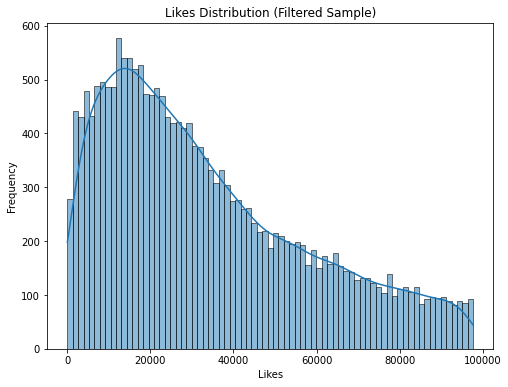

In [57]:
# Get a sample for visualization
sample_likes = df.select("likes").sample(fraction=0.10, seed=42).toPandas()

# Determine a threshold: e.g., the 75th percentile of view counts
threshold = sample_likes["likes"].quantile(0.75)
print("75th percentile of view likes:", threshold)

# Filter the data to include only view counts below the threshold
filtered_sample_likes = sample_likes[sample_likes["likes"] <= threshold]

plt.figure(figsize=(8, 6))
sns.histplot(filtered_sample_likes["likes"], bins=75, kde=True)
plt.title("Likes Distribution (Filtered Sample)")
plt.xlabel("Likes")
plt.ylabel("Frequency")
plt.show()

+-------+-----------------+
|summary|         dislikes|
+-------+-----------------+
|  count|           265251|
|   mean|1123.232323346566|
| stddev|8069.624770429976|
|    min|                0|
|    max|           879354|
+-------+-----------------+

+--------+----------+--------------+
|dislikes|view_count|dislikes_ratio|
+--------+----------+--------------+
|    5855|   1514614|  0.0038656714|
|    2794|   2381688|  0.0011731176|
|    2628|   2038853|    0.00128896|
|    1856|    496771|  0.0037361279|
|     964|   1123889|    8.57736E-4|
+--------+----------+--------------+
only showing top 5 rows

75th percentile of view likes: 0.00054913455


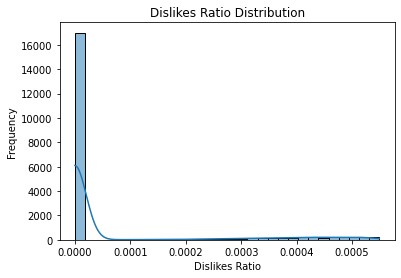

In [58]:
# Summary statistics for dislikes
df.select("dislikes").describe().show()

# Create a ratio column to see likes per view (watch out for division by zero)
df = df.withColumn("dislikes_ratio", F.round(F.col("dislikes") / F.col("view_count"), 10))
df.select("dislikes", "view_count", "dislikes_ratio").show(5)

# Take a 10% sample of the data for visualization (adjust fraction if needed)
sample_dislikes_ratio = df.select("dislikes_ratio").sample(fraction=0.10, seed=42).toPandas()

# Determine a threshold: e.g., the 75th percentile of view counts
threshold = sample_dislikes_ratio["dislikes_ratio"].quantile(0.75)
print("75th percentile of view likes:", threshold)

# Filter the data to include only view counts below the threshold
filtered_sample_dislikes_ratio = sample_dislikes_ratio[sample_dislikes_ratio["dislikes_ratio"] <= threshold]

# Plot the histogram for the likes_ratio distribution
sns.histplot(filtered_sample_dislikes_ratio["dislikes_ratio"], bins=30, kde=True)
plt.title("Dislikes Ratio Distribution")
plt.xlabel("Dislikes Ratio")
plt.ylabel("Frequency")
plt.show()


+-------+------------------+
|summary|     comment_count|
+-------+------------------+
|  count|            265251|
|   mean|10278.154487636239|
| stddev| 73081.39466583014|
|    min|                 0|
|    max|           6738537|
+-------+------------------+

+-------------+----------+--------------------+
|comment_count|view_count|      comments_ratio|
+-------------+----------+--------------------+
|        35313|   1514614|0.023314851176603413|
|        16549|   2381688|0.006948433212074797|
|        40221|   2038853| 0.01972726822384939|
|         7647|    496771|0.015393410645951556|
|         2196|   1123889|0.001953929614045515|
+-------------+----------+--------------------+
only showing top 5 rows

75th percentile of comments ratio: 0.005128069219865673


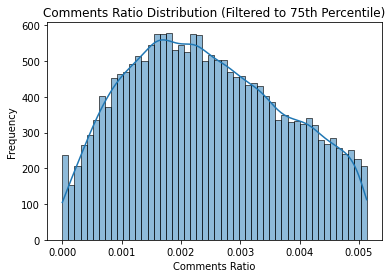

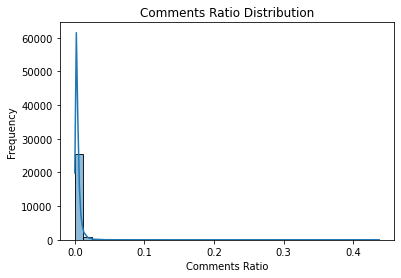

In [59]:
# Summary statistics for comment_count
df.select("comment_count").describe().show()

# Create a ratio column for comments per view
df = df.withColumn("comments_ratio", F.col("comment_count")/F.col("view_count"))
df.select("comment_count", "view_count", "comments_ratio").show(5)

# Take a 10% sample of the data for visualization (adjust fraction if needed)
sample_comments_ratio = df.select("comments_ratio").sample(fraction=0.10, seed=42).toPandas()

threshold = sample_comments_ratio["comments_ratio"].quantile(0.75)
print("75th percentile of comments ratio:", threshold)

# Filter the data to include only view counts below the threshold
filtered_comments_ratio = sample_comments_ratio[sample_comments_ratio["comments_ratio"] <= threshold]

# Plot the histogram with the actual view count values
sns.histplot(filtered_comments_ratio["comments_ratio"], bins=50, kde=True)
plt.title("Comments Ratio Distribution (Filtered to 75th Percentile)")
plt.xlabel("Comments Ratio")
plt.ylabel("Frequency")
plt.show()


# Plot the histogram for the likes_ratio distribution
sns.histplot(sample_comments_ratio["comments_ratio"], bins=35, kde=True)
plt.title("Comments Ratio Distribution")
plt.xlabel("Comments Ratio")
plt.ylabel("Frequency")
plt.show()


In [60]:
df.show(2)

+-----------+--------------------+-------------------+--------------------+------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+------------+----------+------------+-------------+-----------------+------------+-----------+--------------+--------------------+
|   video_id|               title|        publishedAt|           channelId|channelTitle|categoryId|      trending_date|                tags|view_count| likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|title_length|word_count|publish_year|publish_month|publish_dayofweek|publish_hour|likes_ratio|dislikes_ratio|      comments_ratio|
+-----------+--------------------+-------------------+--------------------+------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+------------+----------+---

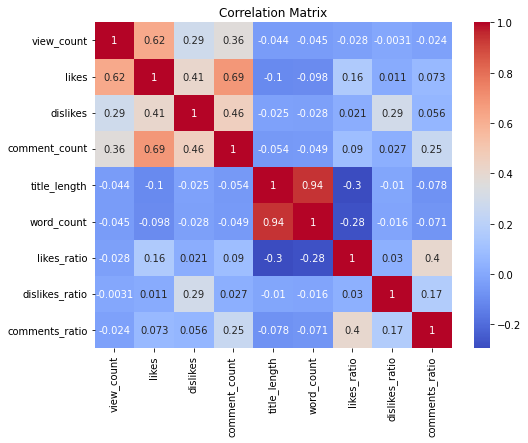

In [61]:
df_numeric = df.select(["view_count", "likes", "dislikes", "comment_count", "title_length", "word_count", "likes_ratio", "dislikes_ratio", "comments_ratio"])

df_numeric_pd = df_numeric.sample(fraction=0.1, seed=42).toPandas()

# Compute the correlation matrix using Pandas
corr_matrix = df_numeric_pd.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

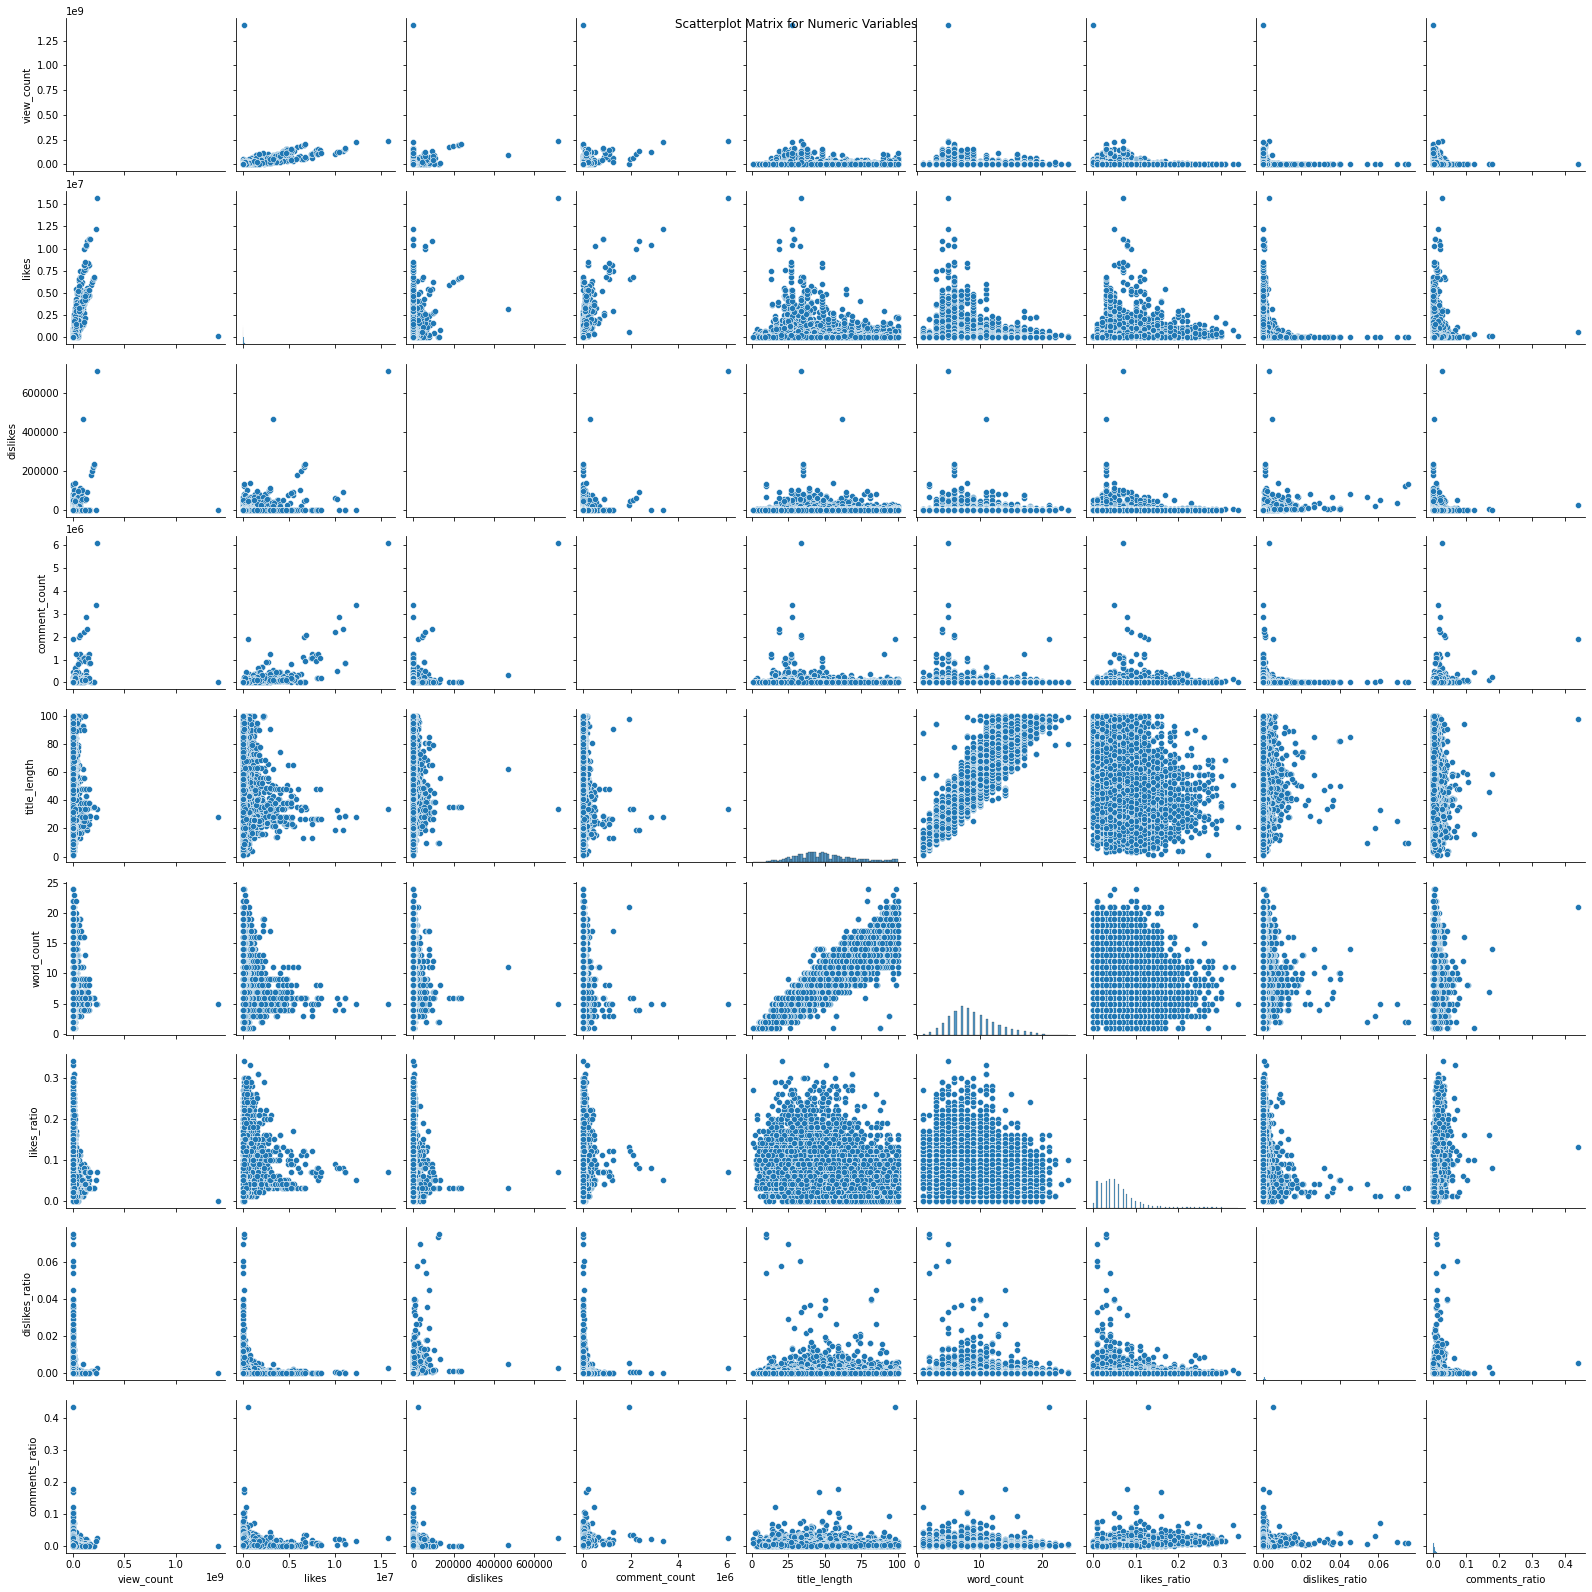

In [62]:
sns.pairplot(df_numeric_pd)
plt.suptitle("Scatterplot Matrix for Numeric Variables")
plt.show()

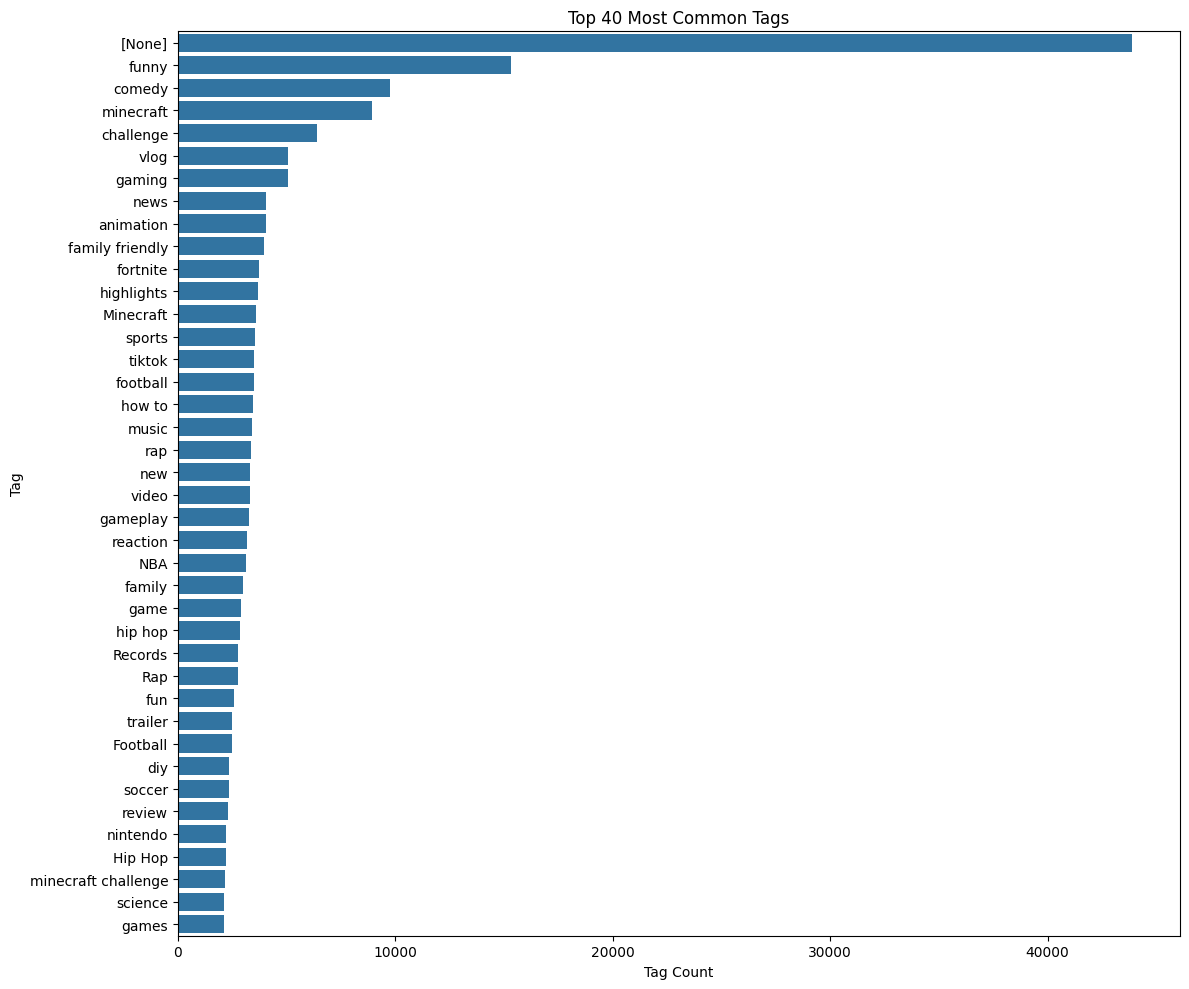

In [9]:
# processing the tags column to individually split each tag and display most common tags
df_tags_split = df.withColumn("tag_array", F.split(F.col("tags"), r"\|"))

# Explode the array to have one tag per row
df_tags_exploded = df_tags_split.select(F.explode(F.col("tag_array")).alias("tag"))

# Clean up whitespace
df_tags_exploded = df_tags_exploded.withColumn("tag", F.trim(F.col("tag")))

# Group by tag and count
tag_counts = df_tags_exploded.groupBy("tag").count().orderBy("count", ascending=False)

# Get the top 40 tags
top_tags = tag_counts.limit(40)

# Convert to Pandas for plotting
top_tags_pd = top_tags.toPandas()

plt.figure(figsize=(12, 10))
sns.barplot(x="count", y="tag", data=top_tags_pd)
plt.title("Top 40 Most Common Tags")
plt.xlabel("Tag Count")
plt.ylabel("Tag")
plt.tight_layout()
plt.show()